# Functions for CMag System Specific Analysis



In [29]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.io
from scipy import stats
import scipy.io as sio
import math

%matplotlib inline
# import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 300
from matplotlib.ticker import FormatStrFormatter
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from functions.functions import load_data_forGridSearch

## Load testing data

In [2]:
# step 1 - load labels and predictions
# load testing data
X_test, y_test = load_data_forGridSearch("../Data", "test")

In [3]:
42721/119

359

## Load and organize prediction results

In [4]:
results = {}
results["X_test"] = X_test
results["labels"] = y_test

In [5]:
# load matlab predictions (recalibrated)
y_pred_baseline_recalibrated = sio.loadmat('./baseline_model/magnetic_model/CalibrateSystem_CardioMag_retrained_w_SensorGrid/mpem_y_pred.mat')['fieldStrength']
y_pred_baseline_recalibrated = y_pred_baseline_recalibrated[:,0:3]
assert y_pred_baseline_recalibrated.shape == y_test.shape, "Predictions for testing set do not have the same shape as the labels"

results["linear multipole electromagnet model"] = y_pred_baseline_recalibrated

In [6]:
# for random forest model

y_pred_rf = np.load("../Models/RF/GridSearch_RF_predictions.npy")

results["RF"] = y_pred_rf

In [7]:
# for ANN
y_pred_MLP =np.load('../Models/ANN/predictions_ANN.npy')

results["MLP"] = y_pred_MLP

## Error by max current among eight coils

In [8]:
def plot_metrics_by_max_current(results_dict):
    
    marker_list = ["o", "D", "s"]
    colour_list = ["b", "k", "g"]
    
    def rounddown(x, level=5.0):
        return int(math.floor(x / level) * level)

    def metrics_by_group(grouped):
        return evaluate_generic_metrics(labels=grouped[["y_true_x", "y_true_y", "y_true_z"]].values,
                                        predictions=grouped[["y_pred_x", "y_pred_y", "y_pred_z"]].values)
    
    def evaluate_generic_metrics(labels, predictions):
    
        # label_norm = np.sqrt(np.sum(labels**2, axis=1))
        # prediction_norm = np.sqrt(np.sum(predictions**2, axis=1))
        label_norm = [np.linalg.norm(y) for y in labels]
        prediction_norm = [np.linalg.norm(y) for y in predictions]
    
        # R^2
        r2_c = r2_score(y_true=labels, y_pred=predictions, multioutput='raw_values')
        r2 = r2_score(y_true=labels, y_pred=predictions)
        r2_norm = r2_score(y_true=label_norm, y_pred=prediction_norm)

        # Root mean squared error
        rmse_c = np.sqrt(mean_squared_error(y_true=labels, y_pred=predictions, multioutput='raw_values'))
        rmse = np.sqrt(mean_squared_error(y_true=labels, y_pred=predictions))
        rmse_norm = np.sqrt(mean_squared_error(y_true=label_norm, y_pred=prediction_norm))

        return {"R2_x": round(r2_c[0], 2),
                "R2_y": round(r2_c[1], 2),
                "R2_z": round(r2_c[2], 2),
                "R2": round(r2, 2),
                "R2_norm": round(r2_norm, 2),
                "RMSE_x_mT": round(rmse_c[0]*1000, 2),
                "RMSE_y_mT": round(rmse_c[1]*1000, 2),
                "RMSE_z_mT": round(rmse_c[2]*1000, 2),
                "RMSE_mT": round(rmse*1000, 2),
                "RMSE_norm_mT": round(rmse_norm*1000,2)} 

    def _plot(X_test, y_test, k, y_pred, idx):

        model_name = k
        # step 1: construct a dataframe for better data manipulation [currents, power, predictions, labels]

        results_data = pd.DataFrame(data=X_test[:, 3:], columns=["I{}".format(a) for a in range(1, 9)])
        results_data['max_currents_mag'] = np.max(np.fabs(results_data), axis=1)
        results_data['current_level'] = results_data['max_currents_mag'].apply(rounddown)

        results_data['y_pred_x'] = y_pred[:, 0]
        results_data['y_pred_y'] = y_pred[:, 1]
        results_data['y_pred_z'] = y_pred[:, 2]
        results_data['y_true_x'] = y_test[:, 0]
        results_data['y_true_y'] = y_test[:, 1]
        results_data['y_true_z'] = y_test[:, 2]

        # group results to evaluate for each power level
        results_by_current = results_data.groupby("current_level").apply(metrics_by_group)
        count_number = results_data.groupby("current_level").size().values
        percentage = [round(i / len(results_data) * 100, 2) for i in count_number]

        currentLists = list(results_by_current.keys())
        R2_list = [results_by_current.get(l)['R2_norm'] for l in currentLists]
        RMSE_list = [results_by_current.get(l)['RMSE_norm_mT'] for l in currentLists]

        # plot two metrics
        # axs[0].scatter(currentLists, R2_list, label=model_name)
        axs[0].plot(currentLists, R2_list, linestyle = "-", marker=marker_list[idx], color=colour_list[idx], label=model_name)
        # axs[0].set_xlabel("\ncurrent level (A)", size=16)
        axs[0].set_ylabel(r"$R_{norm}^2$", size=16)
        axs[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        axs[0].legend(loc="lower left", prop={'size': 14})

        axs[1].plot(currentLists, RMSE_list, linestyle = "-", marker=marker_list[idx], color=colour_list[idx], label=model_name)
        axs[1].set_xlabel("\ncurrent level (A)", size=16)
        axs[1].set_ylabel(r"$RMSE_{norm} (mT)$", size=16)
        axs[1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        axs[1].legend(loc="upper left", prop={'size': 14})
        
        print("R2:", R2_list)
        print("RMSE:", RMSE_list)

        # fig.suptitle(
        #     'model performance evaluation stratified by maximum absolute current among eight coils'.format(
        #         model_name), size=18)
        # TODO: why the xticklabels are shifted, temp solution is to add a blank entry on the top, what is a better solution
        
        plt.setp(axs, xticklabels=['',
                                   '0-5',
                                   '5-10',
                                   '10-15',
                                   '15-20',
                                   '20-25',
                                   '25-30',
                                   '30-35'])
        
    
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))
    for ax in axs:
        ax.tick_params(axis="x", labelsize=12)
        ax.tick_params(axis="y", labelsize=12)


    X_test = results_dict["X_test"]
    y_test = results_dict["labels"]
    prediction_list = list(results_dict)
    prediction_list.remove("X_test")
    prediction_list.remove("labels")

    for idx, k in enumerate(prediction_list):
        _plot(X_test, y_test, k, results_dict[k], idx)
      
    # save figure 
    # fig.savefig("../Figures/metrics_by_current.png", dpi=300)

('R2:', [0.15, 0.78, 0.71, 0.73, 0.67, 0.74, 0.56])
('RMSE:', [6.81, 6.86, 9.51, 10.53, 13.84, 16.12, 20.38])
('R2:', [0.95, 0.97, 0.97, 0.98, 0.98, 0.97, 0.96])
('RMSE:', [1.66, 2.69, 2.86, 2.91, 3.23, 5.11, 5.97])
('R2:', [0.99, 0.99, 0.93, 0.84, 0.57, 0.09, -0.86])
('RMSE:', [0.79, 1.41, 4.48, 8.29, 15.81, 30.26, 41.72])


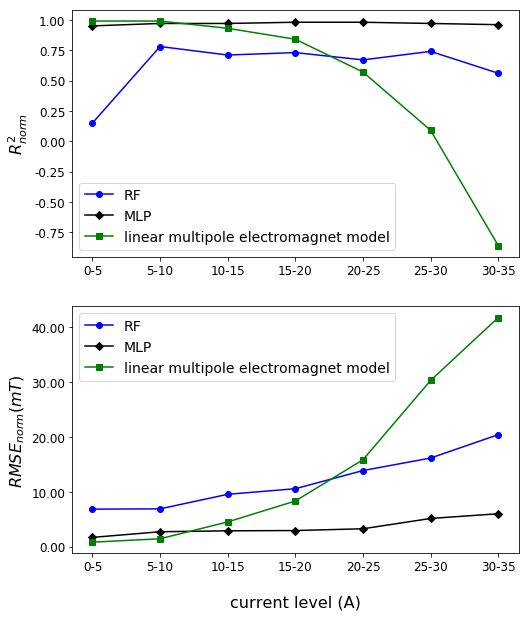

In [9]:
plot_metrics_by_max_current(results)

# Mixing in Results from Deep Fluids

In [10]:
CNN_results = np.load('/home/samuelch/src/deep-fluids/log/notebook/df_results_by_current_level')
CNN_DF_results = np.load('/home/samuelch/src/deep-fluids/log/notebook/df_results_by_current_level_divfree')

In [11]:
def create_results_dict(y_pred):
    def rounddown(x, level=5.0):
        return int(math.floor(x / level) * level)
    
    def metrics_by_group(grouped):
        return evaluate_generic_metrics(labels=grouped[["y_true_x", "y_true_y", "y_true_z"]].values,
                                        predictions=grouped[["y_pred_x", "y_pred_y", "y_pred_z"]].values)
    
    def evaluate_generic_metrics(labels, predictions):
    
        # label_norm = np.sqrt(np.sum(labels**2, axis=1))
        # prediction_norm = np.sqrt(np.sum(predictions**2, axis=1))
        label_norm = [np.linalg.norm(y) for y in labels]
        prediction_norm = [np.linalg.norm(y) for y in predictions]
    
        # R^2
        r2_c = r2_score(y_true=labels, y_pred=predictions, multioutput='raw_values')
        r2 = r2_score(y_true=labels, y_pred=predictions)
        r2_norm = r2_score(y_true=label_norm, y_pred=prediction_norm)

        # Root mean squared error
        rmse_c = np.sqrt(mean_squared_error(y_true=labels, y_pred=predictions, multioutput='raw_values'))
        rmse = np.sqrt(mean_squared_error(y_true=labels, y_pred=predictions))
        rmse_norm = np.sqrt(mean_squared_error(y_true=label_norm, y_pred=prediction_norm))
        mae = mean_absolute_error(y_true=labels, y_pred=predictions)
        nmae = mae / (np.max(predictions) - np.min(predictions))
        return {"R2_x": r2_c[0],
                "R2_y": r2_c[1],
                "R2_z": r2_c[2],
                "R2": r2,
                "MAE_mT": 1000*mae,
                "N-MAE": nmae,
                "R2_norm": round(r2_norm, 2),
                "RMSE_x_mT": round(rmse_c[0]*1000, 2),
                "RMSE_y_mT": round(rmse_c[1]*1000, 2),
                "RMSE_z_mT": round(rmse_c[2]*1000, 2),
                "RMSE_mT": round(rmse*1000, 2),
                "RMSE_norm_mT": round(rmse_norm*1000,2)} 

    # step 1: construct a dataframe for better data manipulation [currents, power, predictions, labels]

    results_data = pd.DataFrame(data=X_test[:, 3:], columns=["I{}".format(a) for a in range(1, 9)])
    results_data['max_currents_mag'] = np.max(np.fabs(results_data), axis=1)
    results_data['current_level'] = results_data['max_currents_mag'].apply(rounddown)

    results_data['y_pred_x'] = y_pred[:, 0]
    results_data['y_pred_y'] = y_pred[:, 1]
    results_data['y_pred_z'] = y_pred[:, 2]
    results_data['y_true_x'] = y_test[:, 0]
    results_data['y_true_y'] = y_test[:, 1]
    results_data['y_true_z'] = y_test[:, 2]
    results_by_current = results_data.groupby("current_level").apply(metrics_by_group)
    return results_by_current

In [12]:
mlp_results = create_results_dict(y_pred_MLP)
linear_results = create_results_dict(y_pred_baseline_recalibrated)
rf_results = create_results_dict(y_pred_rf)

In [13]:
y_pred_s_mpem = np.load('../Models/S-MPEM/predictions_S-MPEM.npy')
s_mpem_results = create_results_dict(y_pred_s_mpem)

In [70]:
marker_list = ["o", "D", "s", 'v', '^', '8']
colour_list = ["tab:blue", "tab:orange", "tab:green", 'tab:red', 'tab:purple', 'tab:brown']
def plot_results(results_dict, model_name, idx):
    currentLists = list(CNN_results.keys())
    R2_list = [results_dict.get(l)['R2'] for l in currentLists]
    RMSE_list = [results_dict.get(l)['RMSE_norm_mT'] for l in currentLists]
    MAE_list = [results_dict.get(l)['MAE_mT'] for l in currentLists]
    
    axs[0].plot(currentLists, R2_list, linestyle = "-", linewidth=2.,
                marker=marker_list[idx], color=colour_list[idx], label=model_name)
    # axs[0].set_xlabel("\ncurrent level (A)", size=16)
    axs[0].set_ylabel(r"$R^2$")
    axs[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    axs[0].legend(loc="lower left")
    axs[0].grid(True)
    
    axs[-1].plot(currentLists, MAE_list, linestyle = "-", linewidth=2.5,
                marker=marker_list[idx], color=colour_list[idx], label=model_name)
    axs[-1].set_xlabel("Current Level (A)")
    axs[-1].set_ylabel(r"MAE (mT)")
    #axs.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    axs[-1].legend(loc="upper left")
    plt.setp(axs, xticklabels=['',
                           '0-5',
                           '5-10',
                           '10-15',
                           '15-20',
                           '20-25',
                           '25-30',
                           '30-35'])
    plt.tight_layout()
    axs[-1].grid(True)
    #axs.minorticks_on()

def plot_results_single(results_dict, model_name, idx):
    currentLists = list(CNN_results.keys())
    R2_list = [results_dict.get(l)['R2'] for l in currentLists]
    RMSE_list = [results_dict.get(l)['RMSE_norm_mT'] for l in currentLists]
    MAE_list = [results_dict.get(l)['MAE_mT'] for l in currentLists]
    plt.plot(currentLists, MAE_list, linestyle = "-", linewidth=1.5, markersize=4.,
                marker=marker_list[idx], color=colour_list[idx], label=model_name)
    plt.xlabel("Current Level (A)")
    plt.ylabel(r"MAE (mT)")
    #axs.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.legend(loc="upper left")
    plt.gca().set_xticklabels(['',
                           '0-5',
                           '5-10',
                           '10-15',
                           '15-20',
                           '20-25',
                           '25-30',
                           '30-35'])
    plt.tight_layout()
    plt.grid(True)

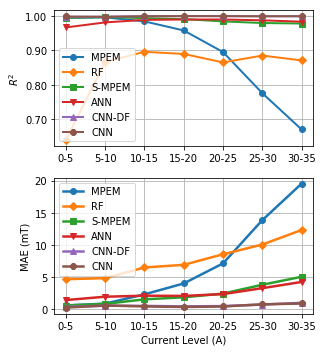

In [15]:
fig, axs = plt.subplots(2, 1, figsize=(4.6, 5))

plot_results(linear_results, 'MPEM',0, )
plot_results(rf_results, 'RF', 1)
plot_results(s_mpem_results, 'S-MPEM', 2)
plot_results(mlp_results, 'ANN', 3)
plot_results(CNN_DF_results, 'CNN-DF', 4)
plot_results(CNN_results, 'CNN', 5)

#plt.savefig('../Figures/current_levels.pdf')

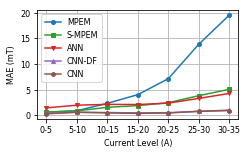

In [71]:
# plot for IEEE submission
mpl.rcParams.update({'font.size': 8,
                    'lines.linewidth': 1.5})
fig = plt.figure(figsize=(3.5, 2.2))

plot_results_single(linear_results, 'MPEM',0)
#plot_results(rf_results, 'RF', 1)
plot_results_single(s_mpem_results, 'S-MPEM', 2)
plot_results_single(mlp_results, 'ANN', 3)
plot_results_single(CNN_DF_results, 'CNN-DF', 4)
plot_results_single(CNN_results, 'CNN', 5)

plt.savefig('../Figures/current_levels_ieee.pdf')

In [53]:
%matplotlib inline

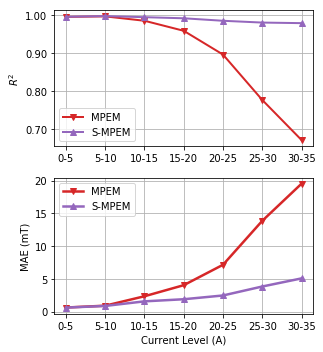

In [54]:
# plot for nonlinear chapter of thesis
fig, axs = plt.subplots(2, 1, figsize=(4.6, 5))
plot_results(linear_results, 'MPEM',3)
plot_results(s_mpem_results, 'S-MPEM',4)
plt.savefig('../Figures/current_levels_s-mpem.pdf')

In [70]:
print('percentage error at different current levels between MPEM and S-MPEM')
for r_mpem, r_smpem in zip(linear_results, s_mpem_results):
    print('k: 100*(r-mpem['MAE_mT'] - r-smpem['MAE_mT']) / r-mpem['MAE_mT']

[1.8902908992833043,
 4.335177050067925,
 33.376127215562626,
 53.40405057935249,
 65.69309325948534,
 72.43495937631273,
 74.09311529130062]

In [86]:
for k, r_mpem, r_smpem in zip(linear_results.keys(), linear_results, s_mpem_results):
    percent_error = 100*(r_mpem['MAE_mT'] - r_smpem['MAE_mT']) / r_mpem['MAE_mT']
    print('current: {}, \terror: {:2.1f}%'.format(k, percent_error))

current: 0, 	error: 1.9%
current: 5, 	error: 4.3%
current: 10, 	error: 33.4%
current: 15, 	error: 53.4%
current: 20, 	error: 65.7%
current: 25, 	error: 72.4%
current: 30, 	error: 74.1%


In [65]:
linear_results[10]

{'MAE_mT': 2.3283588717800576,
 'N-MAE': 0.009579058587377579,
 'R2': 0.9842199374824228,
 'R2_norm': 0.93,
 'R2_x': 0.9910228926936707,
 'R2_y': 0.9873462816034843,
 'R2_z': 0.9742906381501134,
 'RMSE_mT': 3.2,
 'RMSE_norm_mT': 4.48,
 'RMSE_x_mT': 2.98,
 'RMSE_y_mT': 3.1,
 'RMSE_z_mT': 3.5}